In [1]:
import pandas as pd
import scipy.stats as stats
import random
import numpy as np

In [2]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,10)

In [3]:
import src.gas as g

In [4]:
gas=g.getHistorical()

In [5]:
pool_data=pd.read_csv('../data/pool_data.csv',parse_dates=['date'])

In [6]:
pool_data

,date,tvlUSD,volumeUSD,feesUSD,pool_id,pool_name
0,2021-05-24,403892.931715,1.560326e+05,78.016302,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
1,2021-05-25,627333.528404,1.641681e+06,820.840475,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
2,2021-05-26,641104.310366,1.581438e+05,79.071880,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
3,2021-05-27,641137.824278,6.312746e+04,31.563732,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
4,2021-05-28,522950.055411,3.004094e+05,150.204708,0x00cef0386ed94d738c8f8a74e8bfd0376926d24c,BUSD_USDC_05
...,...,...,...,...,...,...
3828,2022-10-21,332852.727774,2.582470e+04,12.912351,0xd5ad5ec825cac700d7deafe3102dc2b6da6d195d,BUSD_USDT_05
3829,2022-10-22,332868.272886,1.235443e+04,6.177214,0xd5ad5ec825cac700d7deafe3102dc2b6da6d195d,BUSD_USDT_05
3830,2022-10-23,332885.856963,2.821563e+04,14.107815,0xd5ad5ec825cac700d7deafe3102dc2b6da6d195d,BUSD_USDT_05
3831,2022-10-24,332908.083203,4.801312e+04,24.006560,0xd5ad5ec825cac700d7deafe3102dc2b6da6d195d,BUSD_USDT_05


In [7]:
start_date=pool_data[pool_data.pool_name=='USDC_USDT_01'].date.min()
pool=pool_data[(pool_data.pool_name=='USDC_USDT_05') & (pool_data.date>=start_date)].reset_index(drop=True)

In [8]:
env=pool[['date','tvlUSD','feesUSD']].merge(gas[['date','reinvest']])
env

,date,tvlUSD,feesUSD,reinvest
0,2021-11-13,1.234707e+08,7664.013660,443.950308
1,2021-11-14,1.234439e+08,5251.468545,383.639671
2,2021-11-15,1.225704e+08,14867.525610,509.770278
3,2021-11-16,1.171935e+08,20997.540933,444.188143
4,2021-11-17,5.565470e+07,2649.472895,412.526295
...,...,...,...,...
340,2022-10-19,2.439499e+07,1514.302855,29.802768
341,2022-10-20,2.440134e+07,1642.421502,31.753354
342,2022-10-21,2.467383e+07,1149.828502,31.245179
343,2022-10-22,2.493749e+07,413.049380,20.143944


In [9]:
e=env.copy()

In [39]:
def get_sample(history,p_val):
    return history.sort_values(ascending=True).iloc[:int(len(history)*(1-p_val))]

def get_projected_return(sample,projection_p_value,day_count):
    fit_a,fit_loc,fit_scale=stats.skewnorm.fit(sample)
    fit_mean,fit_variance=stats.skewnorm.stats(a=fit_a,loc=fit_loc,scale=fit_scale,moments='mv')
    norm_mean=fit_mean*day_count
    norm_std=(fit_variance*day_count)**(.5)
    lower_bound,upper_bound=stats.norm.interval(1-2*projection_p_value,loc=norm_mean,scale=norm_std)
    return lower_bound

def run_iteration(day_projection,projection_p_value,fit_p_value,environment,initial_capital,test_size):
    env=environment.copy()
    start_index=int(len(env)*test_size)
    current_capital=initial_capital
    env.loc[start_index:,'tvlUSD']=env.iloc[start_index:].tvlUSD+initial_capital
    env['returns']=env.feesUSD/env.tvlUSD
    unclaimed_fees=0

    log_rows=[]

    for index,row in env.iloc[start_index:].iterrows():

        unclaimed_fees=unclaimed_fees+row.returns*current_capital

        history=env.iloc[:index].returns
        sample=get_sample(history,fit_p_value)
        projected_return=get_projected_return(sample,projection_p_value,day_projection)
        projected_fees=projected_return*unclaimed_fees

        log_rows.append({
            'date':row.date,
            'current_capital':current_capital,
            'unclaimed_fees':unclaimed_fees,
            'projected_fees':projected_fees,
            'reinvest_cost':row.reinvest
        })

        if projected_fees>row.reinvest and unclaimed_fees>row.reinvest:
            reinvest_sum=unclaimed_fees-row.reinvest
            current_capital=current_capital+reinvest_sum
            unclaimed_fees=0

    results=pd.DataFrame(log_rows)
    results['fit_p_value']=fit_p_value
    results['projection_p_value']=projection_p_value
    results['day_projection']=day_projection
    results['test_size']=test_size
    return results

def run(file_location):
    df=None
    for p_val in np.linspace(.02,.2,10):
        for days in np.linspace(7,49,7,dtype=int):
            print(f'Simulating. p value: {p_val} , days: {days}')
            results=run(days,p_val)
            if df is None:
                df=results
            else:
                df=pd.concat([df,results]).reset_index(drop=True)
            df.to_csv(file_location,index=False)

In [40]:
results=run_iteration(20,.05,.02,e,1000000,.3)

In [41]:
results

,date,current_capital,unclaimed_fees,projected_fees,reinvest_cost,fit_p_value,projection_p_value,day_projection,test_size
0,2022-02-24,1.000000e+06,101.056567,0.136315,166.441363,0.02,0.05,20,0.3
1,2022-02-25,1.000000e+06,146.983887,0.198470,132.462342,0.02,0.05,20,0.3
2,2022-02-26,1.000000e+06,185.571526,0.250043,108.350535,0.02,0.05,20,0.3
3,2022-02-27,1.000000e+06,205.172566,0.275628,85.742433,0.02,0.05,20,0.3
4,2022-02-28,1.000000e+06,262.102024,0.347649,151.682107,0.02,0.05,20,0.3
...,...,...,...,...,...,...,...,...,...
237,2022-10-19,1.025778e+06,2823.267343,3.737657,29.802768,0.02,0.05,20,0.3
238,2022-10-20,1.025778e+06,2889.592975,3.823129,31.753354,0.02,0.05,20,0.3
239,2022-10-21,1.025778e+06,2935.533490,3.881848,31.245179,0.02,0.05,20,0.3
240,2022-10-22,1.025778e+06,2951.868802,3.900390,20.143944,0.02,0.05,20,0.3


In [42]:
last_row=results.iloc[-1]
((last_row.current_capital+last_row.unclaimed_fees)/1000000-1)*365/len(results)

0.043381846305142344

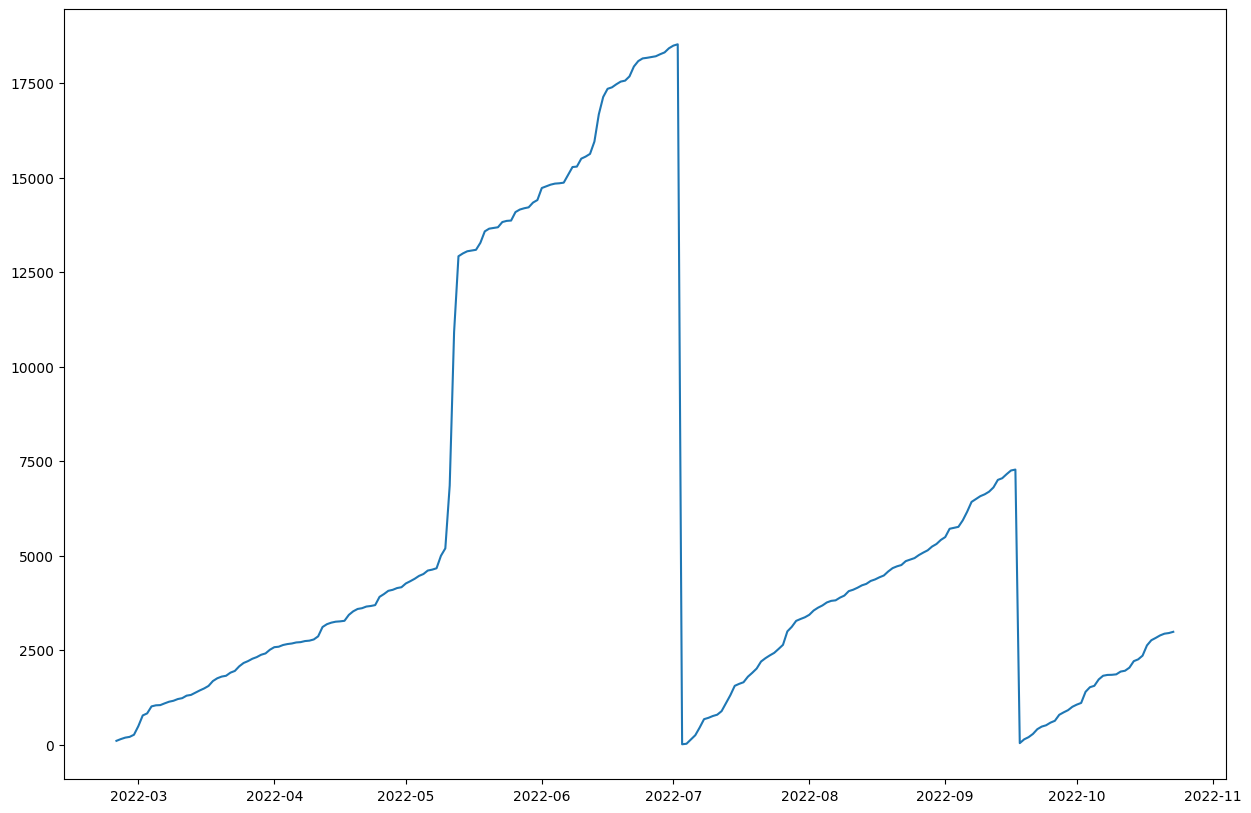

In [43]:
plt.plot(results.date,results.unclaimed_fees)